本实验的目的是想要使用不同股票对模型进行训练，观察其是否还能够对任意股票价格进行预测。

1. 数据准备

In [1]:
import pymysql
from datetime import date
from sklearn.preprocessing import MinMaxScaler
db = pymysql.connect(host='localhost',user='root',password='123456',database='stock_info')
cursor = db.cursor()
sc = MinMaxScaler(feature_range=[0,1])

In [ ]:
# 先获取沪深300股票列表
# cursor.execute("select code, date from hs300_details where is_exist=1 and date < '2018-01-01';")
# train_list = list(cursor.fetchall())
# cursor.execute("select code, date from hs300_details where is_exist=1 and date >= '2018-01-01';")
# test_list = list(cursor.fetchall())

In [2]:
# 获取ETF的历史股价
# 创业板ETF
train_data_list = []
cursor.execute("select code,date,close from stock_price_pool where code = '159915.XSHE'")
train_data_list.append(list(cursor.fetchall()))
# 沪深300ETF
cursor.execute("select code,date,close from stock_price_pool where code = '510300.XSHG'")
train_data_list.append(list(cursor.fetchall()))
# 南方中证500ETF
cursor.execute("select code,date,close from stock_price_pool where code = '510500.XSHG'")
train_data_list.append(list(cursor.fetchall()))

In [45]:
train_data_list = []
# 沪深300指数-最高价
cursor.execute("select code,date,high from stock_price_pool where code = '000300.XSHG'")
train_data_list.append(list(cursor.fetchall()))
# 沪深300指数-最低价
cursor.execute("select code,date,low from stock_price_pool where code = '000300.XSHG'")
train_data_list.append(list(cursor.fetchall()))
# 沪深300指数-收盘价
cursor.execute("select code,date,close from stock_price_pool where code = '000300.XSHG'")
train_data_list.append(list(cursor.fetchall()))

In [3]:
# train_data_list = []
# for stock in train_list:
#     cursor.execute("select code, date, close from hs300_stock_price_pool where code='%s' order by date asc;" % stock[0])
#     train_data_list.append(list(cursor.fetchall()))

# test_data_list = []
# for stock in test_list:
#     cursor.execute("select code, date, close from hs300_stock_price_pool where code='%s' order by date asc;" % stock[0])
#     test_data_list.append(list(cursor.fetchall()))


In [3]:
from keras import layers
from keras import models


def model_define():
    model = models.Sequential()
    model.add(layers.GRU(50,return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.GRU(50,return_sequences=True))
    #model.add(layers.Dropout(0.2))
    model.add(layers.GRU(50))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=1))
    return model


In [4]:
import numpy as np
import pandas as pd


def dataset_prepare(one_stock_price_list,test_radio,step):
    # 先把元组格式拆分
    stock_price_list = [stock[2] for stock in one_stock_price_list]
    # 划分训练集和数据集
    label = int((1-test_radio)*len(stock_price_list))
    train_set = np.asarray(stock_price_list[:label]).reshape(-1,1)
    test_set = np.asarray(stock_price_list[label-30:]) .reshape(-1,1)

    # 归一化
    
    train_set_scaled = sc.fit_transform(train_set)
    test_set_scaled = sc.transform(test_set)

    # 按照步长转换训练集和测试集
    x_train = []
    y_train = []
    for i in range(step,train_set_scaled.shape[0]):
        x_train.append(train_set_scaled[i-step:i])
        y_train.append(train_set_scaled[i,0])

    x_test = []
    y_test = []
    for i in range(step,test_set_scaled.shape[0]):
        x_test.append(test_set_scaled[i-step:i,0])
        y_test.append(test_set_scaled[i,0])

    x_train,y_train = np.array(x_train),np.array(y_train)
    x_test,y_test = np.array(x_test),np.array(y_test)
    x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
    
    return x_train,y_train,x_test,y_test

In [5]:
import pickle
def one_dataset_prepare(one_stock_price_list,step):
    # 先把元组格式拆分
    stock_code = one_stock_price_list[0][0]
    stock_price_list = [stock[2] for stock in one_stock_price_list]
    # 划分训练集和数据集
    train_set = np.asarray(stock_price_list[:]).reshape(-1,1)

    # 归一化
    # sc = MinMaxScaler(feature_range=[0,1])
    train_set_scaled = sc.fit_transform(train_set)
    
    # 存储sc，以便预测时使用
    # with open(os.path.join(model_dir,stock_code+'.sc'),'w') as f:
    #     f.write(pickle.dumps(sc))

    # 按照步长转换训练集和测试集
    x_train = []
    y_train = []
    for i in range(step,train_set_scaled.shape[0]):
        x_train.append(train_set_scaled[i-step:i])
        y_train.append(train_set_scaled[i,0])
    x_train,y_train = np.array(x_train),np.array(y_train)

    
    return x_train,y_train #,x_test,y_test

In [21]:
from keras.metrics import MeanAbsoluteError
def fit_model(model,x_train,y_train):
    # 模型编译
    model.compile(optimizer='rmsprop',loss='mse',metrics=['acc'])
    # 模型训练
    history = model.fit(x_train,y_train,validation_split=0.1,epochs=60,batch_size=64)
    return model,history

In [7]:
import matplotlib.pyplot as plt
def show_info(history):
    loss = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    #plt.figure(figsize=(25, 9))
    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss_values,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


In [8]:
def show_predict(model,x_test,y_test,train_data_list):
    predict_price = model.predict(x_test)
    predict_price = sc.inverse_transform(predict_price)
    true_price = sc.inverse_transform(y_test.reshape(-1,1))
    stock_name = train_data_list[0][0]
    date_list = [x[1] for x in train_data_list]
    true_pd = pd.DataFrame(data = true_price, index=date_list[len(date_list) - len(true_price):])
    predict_pd = pd.DataFrame(data=predict_price, index=date_list[len(date_list) - len(true_price):])
    plt.figure(figsize=(25, 9))
    plt.plot(true_pd, color='red',label="{} predict stock_price".format(stock_name))
    plt.plot(predict_pd ,color='blue',label='{} true stock price'.format(stock_name))
    plt.title("{} stock price".format(stock_name))
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()
    return true_pd,predict_pd
    

2. 定义一个训练函数

In [10]:
def train_and_show(train_data_list,index,step,save_path,label_name):
    x_train,y_train,x_test,y_test = dataset_prepare(train_data_list[index],0.2,step)
    model = model_define()
    model,history = fit_model(model,x_train,y_train)
    show_info(history)
    true_pd,predict_pd = show_predict(model,x_test,y_test,train_data_list[index])
    model.save('{}/{}-{}.h5'.format(save_path,train_data_list[index][0][0],label_name))
    return true_pd,predict_pd

In [9]:
import os
from keras.models import load_model
model_dir = "D:\\models"
def one_day_predict(code,history):
    model = load_model(os.path.join(model_dir,code+'.h5'))
    history = sc.transform(history)
    history = np.reshape(history,(1,30,1))
    predict_value = model.predict(history)
    predict_value = sc.inverse_transform(predict_value.reshape(-1,1))
    return predict_value[0][0]

Epoch 1/60
29/29 [==============================] - 8s 83ms/step - loss: 0.0092 - acc: 0.0011 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 2/60
29/29 [==============================] - 1s 44ms/step - loss: 0.0046 - acc: 0.0011 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 3/60
29/29 [==============================] - 1s 45ms/step - loss: 0.0041 - acc: 0.0011 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 4/60
29/29 [==============================] - 1s 49ms/step - loss: 0.0033 - acc: 0.0011 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 5/60
29/29 [==============================] - 1s 49ms/step - loss: 0.0031 - acc: 0.0011 - val_loss: 0.0052 - val_acc: 0.0000e+00
Epoch 6/60
29/29 [==============================] - 1s 46ms/step - loss: 0.0028 - acc: 0.0011 - val_loss: 3.5998e-04 - val_acc: 0.0000e+00
Epoch 7/60
29/29 [==============================] - 1s 50ms/step - loss: 0.0030 - acc: 0.0011 - val_loss: 5.6671e-04 - val_acc: 0.0000e+00
Epoch 8/60
29/29 [=============================

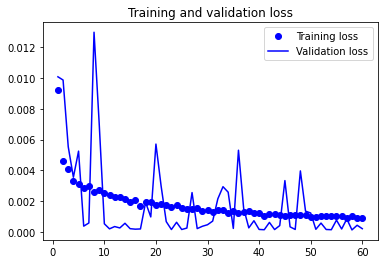

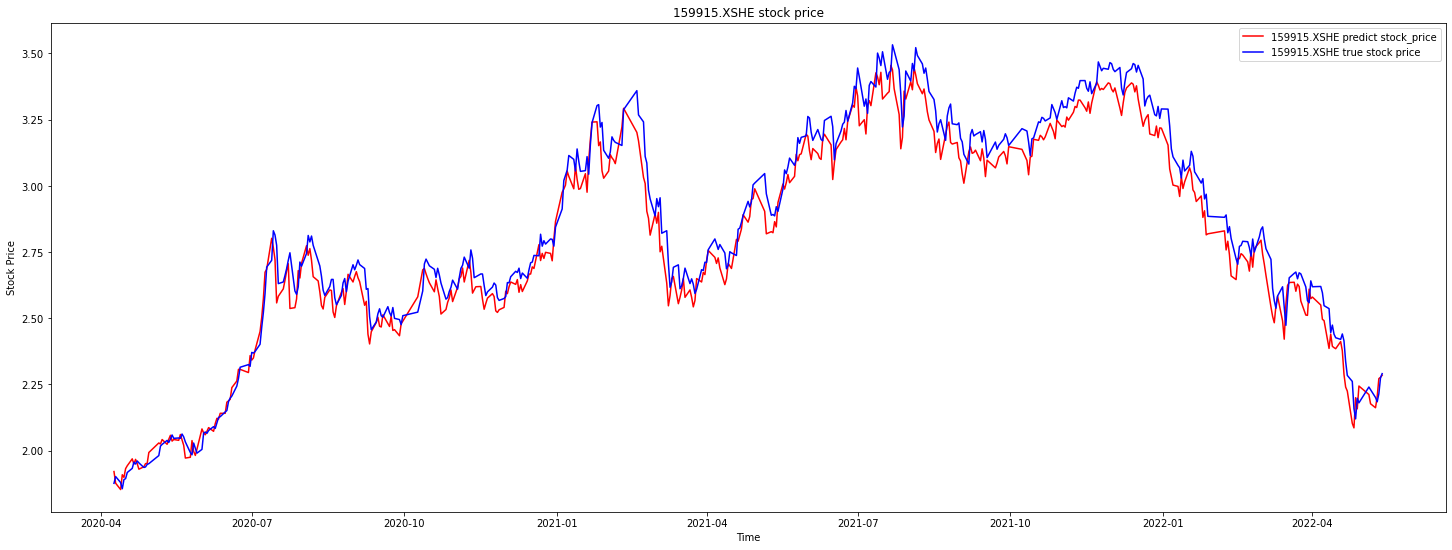

In [22]:
true_pd,predict_pd = train_and_show(train_data_list,0,30,"D:\\models-new","")

In [34]:
x_train,y_train,x_test,y_test = dataset_prepare(train_data_list[0],0.2,30)

In [45]:
with open("D:\\models\\{}.sc".format("000300.XSHG-close"),"wb") as f:
    f.write(pickle.dumps(sc))

In [48]:
mymodel = load_model("G:\\models\\159915.XSHE.h5")
x_train,y_train,x_test,y_test = dataset_prepare(train_data_list[0],0.2,30)

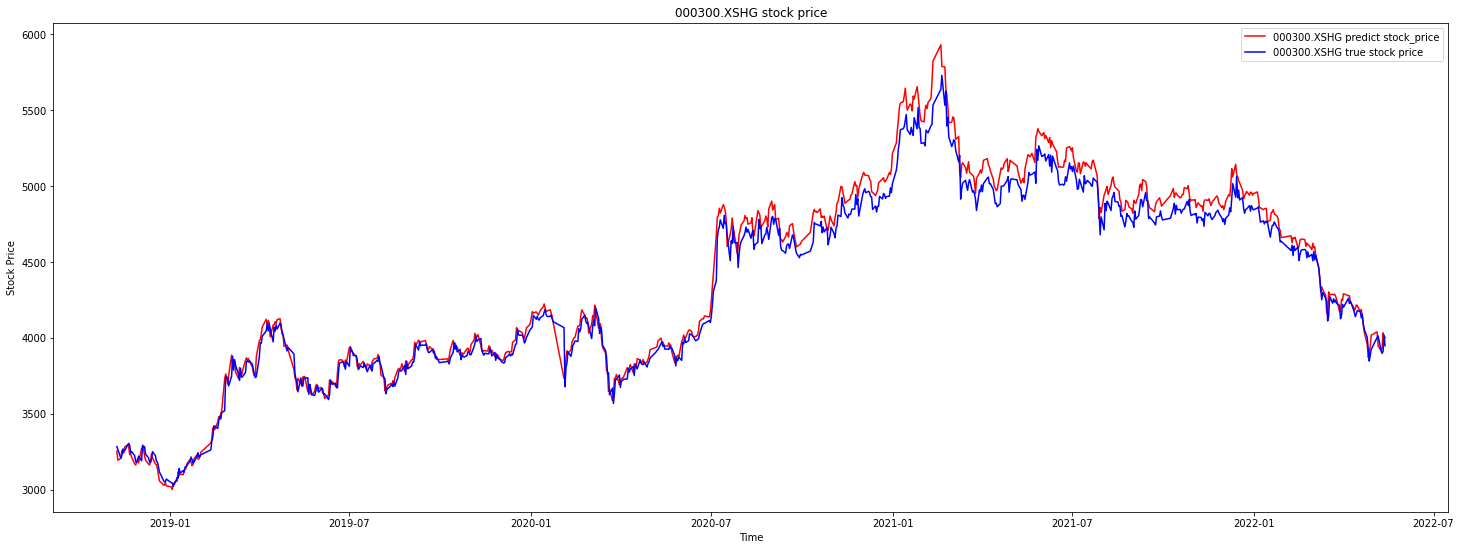

In [49]:
true_info,predict_info = show_predict(mymodel,x_test,y_test,train_data_list[0])

In [13]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from scipy.stats import pearsonr
def test_accuracy(true_info,predict_info):
    mae = mean_absolute_error(np.array(true_info[0]),np.array(predict_info[0]))
    mse = mean_squared_error(np.array(true_info[0]),np.array(predict_info[0]))
    mape = mean_absolute_percentage_error(np.array(true_info[0]),np.array(predict_info[0]))
    rxy = pearsonr(np.array(true_info[0]),np.array(predict_info[0]))
    print("MAE:{} \nMSE:{}\nMAPE:{}\nRXY:{}".format(mae,mse,mape,rxy))

In [23]:
test_accuracy(true_pd,predict_pd)

MAE:0.061248034707171176 
MSE:0.00581515451683233
MAPE:0.02170008830935972
RXY:(0.9916625885976503, 0.0)


In [14]:
test_accuracy(true_info,predict_info)

NameError: name 'true_info' is not defined